# Uncertainty Learning: fNIRS Finger Tapping 

*Oct 21, 2022* 


#### Overview
In this notebook we will  model the [fNIRS finger tapping experiment dataset](https://github.com/rob-luke/BIDS-NIRS-Tapping) collected by [Robert Luke](https://www.linkedin.com/in/rob--luke/?originalSubdomain=au) with *uncertainty learning* - training a model in a way that helps it quantify its own uncertainty about a prediction.  We use the dirichlet mse loss described in the paper [Evidential Deep Learning to Quantify Classification Uncertainty](https://arxiv.org/abs/1806.01768)



#### Data
The dataset consists of fNIRS recording from 5 subjects who are given an audio stimulus in their left or right ear (or a control silent stimulus) in which case they need to respond by tapping fingers on their left or right hand, resp (or do not tap during control).  Each stimulus and subsequent recording corresponds to an experimental trial.  For each of the 5 subjects there are 30 tapping/left, 30 tapping/right and 30 control trials.

#### Models
We will build intra-subject neural network classifiers which attempt to decode the trials from the fNIRS recording.  That is, for each subject we build a classifier which takes as input the (processed and scaled) fNIRS data and as its output a label in ["tapping/left", "tapping/right", "control"].  Because of the limited data size (90 examples per subject) we run modeling as a kfold cross validation and report summary metrics over the folds - we do not extract a hold out test set as our purpose is not to train a classifier to perform in the wild but simply to investigate the validitity of uncertainty learning on this dataset.


#### Note
This notebook is self-contained other than the dataset.  This makes it somewhat lengthy as we need to build up all the data loading code as well as the uncertainty loss code etc.  



In [2]:
import os
import sys 
from collections import defaultdict
from pathlib import Path
from time import time
import platform
import pickle 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick

import torch
from torch import nn 



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import mne
import mne_nirs

import uncertainty_loss as ul
from fnirs_finger_tapping import FingerTapping, FingerTappingDataset

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Python version: {platform.python_version()}")
print(f'PyTorch version {torch.__version__}')
print(f'Device: {DEVICE}')


%load_ext autoreload
%autoreload 2

/Users/bp/Library/Caches/pypoetry/virtualenvs/uncertainty-loss-pB3lvYW1-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.9.13
PyTorch version 1.12.1
Device: cpu


In [3]:
ul.uniform_dirichlet_kl(torch.tensor([1000,0,0]).reshape(1,-1), torch.tensor([1]))

tensor(11.1277)

----
## Preparation

### Set a base random seed for reproducibility

In [4]:
RANDOM_SEED = 20200509

### Load datasets

In [5]:
ft = FingerTapping('data')

### Plot training data 

We plot the training data for a single subject for visual inspection.  The plot below shows the average response of each channel over all trials of a specific class.  For example, the orange lines correspond to the 30 Hbo channels during the control trials, averaged over each of those control trials. 

Notice that in the control trials the curves remain relatively flat, while in the finger tapping trials there tends to be a relatively strong response after the stimulus is presented.

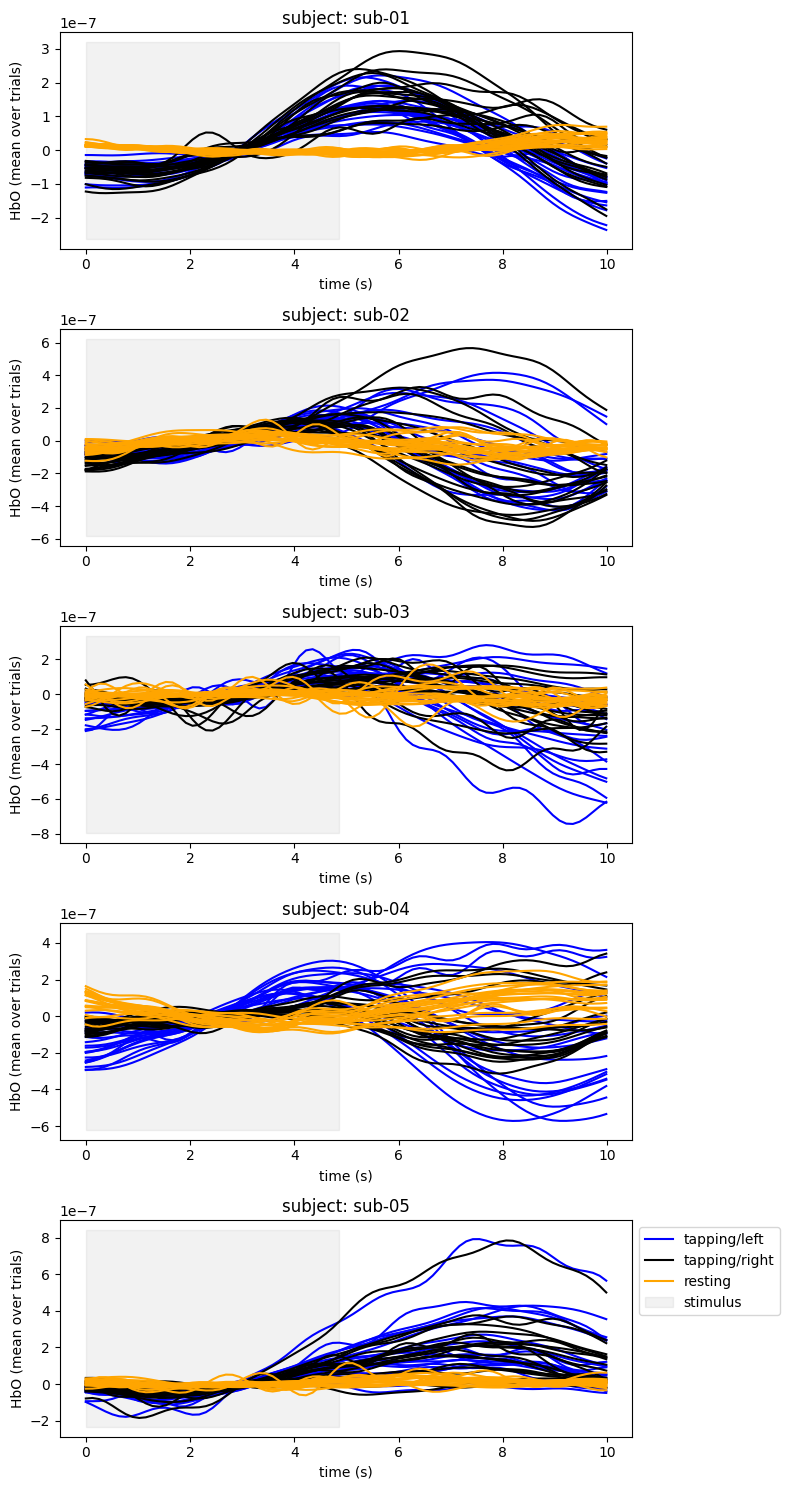

In [6]:
def plot_trial_average_channels(ft:FingerTapping):
    ids = ft.subject_ids()
    fig, axes = plt.subplots(len(ids),1, figsize=(8,3*len(ids)))
    for i, ax in enumerate(axes.ravel()):
        id = ids[i]
        x,y = ft.dataset(id)
        times = ft.times(id)
        ax.plot(times, np.mean(x[y==1], axis=0).T, color='blue', label='tapping/left')
        ax.plot(times, np.mean(x[y==2], axis=0).T, color='black', label='tapping/right')
        ax.plot(times, np.mean(x[y==0], axis=0).T, color='orange', label='resting')
        ax.fill_between(times[:len(times)//2], *ax.get_ylim(), color='gray', alpha=0.1, label='stimulus')
        ax.set_title(f'subject: {id}')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('HbO (mean over trials)')
        if i ==0:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            legend = plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1,1))
    
    fig.tight_layout()
    return fig, ax
        

_ = plot_trial_average_channels(ft)

### Preprocessing

We will scale the data for each channel in preparation for model training.

In [7]:
class PerChannelScaler(BaseEstimator, TransformerMixin):
    """Find per channel mean and std and normalize accordingly    
    """

    def __init__(self, axis=1):
        super().__init__()
        self.axis = axis
    
    def fit(self, X,y=None):
        X = X.copy()
        mu, sigma = self.per_channel_mean_and_std(X)
        self.mean = mu
        self.std = sigma
        
        return self
        
    def transform(self, X, y=None):
        X = X.copy()
        return (X- self.mean) / self.std
    

    def per_channel_mean_and_std(self, X):
        axis = tuple([i for i in range(len(X.shape)) if i != self.axis])
        mu = np.expand_dims(np.mean(X, axis=axis), axis=axis)
        sigma = np.expand_dims(np.std(X, axis=axis), axis=axis)
        return mu, sigma

----
## Model

The model architecture we choose is a Convolutional Neural Network where the convolutions are taken over the time domain. 

### Set up the model

In [15]:
class ConvNet(nn.Module):
    """One dimensional CNN for fnirs classification."""

    def __init__(self, 
        activation=None,
        input_timesteps = 79, 
        hidden_dim=128, 
        dropout=0.3,
        kernel_size_1 = 3,
        kernel_size_2 = 3,
        kernel_maxpool = 2,
        ):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=kernel_size_1, padding='valid')
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=kernel_size_2)
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_maxpool)
        self.flatten = nn.Flatten()

        _timesteps = input_timesteps - kernel_size_1 + 1
        _timesteps = _timesteps - kernel_size_2 + 1
        _timesteps = int((_timesteps - kernel_maxpool) // kernel_maxpool +1)
        flatten_size = _timesteps * 40

        self.batch_norm1 = nn.BatchNorm1d(flatten_size)
        self.fc1 = nn.Linear(flatten_size, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)
        self.activation = activation
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.batch_norm1(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.batch_norm2(x)
        x = self.fc2(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

### Some torch specific helpers

In [16]:
def make_dataloader(x,y, **kwargs):
    """Make a dataloader for the given data."""
    dataset = FingerTappingDataset(x,y)
    return torch.utils.data.DataLoader(dataset, **kwargs)

### Loss Function Wrapper

We wrap the evidential deep learning loss function in a class so we can automatically anneal the regularization factor during training.

In [17]:
class EDLLoss(nn.Module):
    """Expectation over the loss function.
    """
    def __init__(self, reg_steps:int, max_reg:int=1, start_reg=0.0):
        super().__init__()
        self.reg_steps = reg_steps
        self.max_reg = max_reg
        self.reg_step_size = 1 / self.reg_steps
        self.reg_factor = start_reg

    def forward(self, evidence, y):
        return ul.evidential_loss(evidence, y, self.reg_factor)

    def step(self):
        self.reg_factor = min(self.reg_factor + self.reg_step_size, self.max_reg)

    def reset(self):
        self.reg_factor = 0.0

In [41]:
def uncertainty(evidence):
    r"""Computes uncertainty from the model evidence.
    Args:
        evidence (Tensor): Evidence of model output.  The evidence is any non-negative 
            transformation math:`g(x)` of the raw unnormalized model outputs 
            math:`x`.  For example `g=relu(x)`, `g=exp(x)` etc.
    Returns:
        A tensor of shape (batch_size), uncertainty score for
        each element in the batch.
    """
    num_classes = evidence.shape[-1]
    alpha = evidence + 1
    return num_classes / torch.sum(alpha, -1)

def cross_entropy_uncertainty(logits):
    r"""Computes uncertainty from the model logits.
    Args:
        logits (Tensor): Raw unnormalized model outputs.
    Returns:
        A tensor of shape (batch_size), uncertainty score for
        each element in the batch.
    """
    return 1 - torch.max(F.softmax(logits, dim=1), dim=1).values

def maxnorm_uncertainty(evidence):
    r"""Computes uncertainty from the model evidence.
    Args:
        evidence (Tensor): Evidence of model output.  The evidence is any non-negative 
            transformation math:`g(x)` of the raw unnormalized model outputs 
            math:`x`.  For example `g=relu(x)`, `g=exp(x)` etc.
    Returns:
        A tensor of shape (batch_size), uncertainty score for
        each element in the batch.
    """
    alpha = evidence + 1
    s_alpha = torch.sum(alpha, dim=1, keepdim=True)
    div_term = alpha/s_alpha
    return -torch.sum(div_term * torch.log(div_term), dim=1)


def uncertainty_hit_miss(y_pred, y_true, uncert):
    r"""Computes the hit and miss rates for a given uncertainty threshold.
    Args:
        y_pred (Tensor): Predicted class indicies.
        y_true (Tensor): Ground truth class indicies.
        uncert (Tensor): Uncertainty score for each element in the batch.
    Returns:
        A tuple of hit and miss rates.
    """
    hits = y_pred == y_true 
    misses = y_pred != y_true
    hit_acc = torch.mean(uncert[hits])
    miss_acc = torch.mean(uncert[misses])
    return hit_acc, miss_acc 


def certainty(evidence):
    r"""Computes certainty from the model evidence.
    Args:
        evidence (Tensor): Evidence of model output.  The evidence is any non-negative 
            transformation math:`g(x)` of the raw unnormalized model outputs 
            math:`x`.  For example `g=relu(x)`, `g=exp(x)` etc.`.
    Returns:
        A tensor of shape (batch_size), certainty score for
        each element in the batch.
    """
    return 1 - uncertainty(evidence)


def probability(evidence):
    r"""Computes the mode of the dirichlet distribution corresponding to the 
    evidence.
    Args:
        evidence: Tensor of shape (batch_size, num_classes) corresponding
            to the evidence of the model. The evidence is defined as any
            non-negative transformation :math:`g(x)` of the logits :math:`x`.
    Returns:
        A tensor of shape (batch_size, num_classes), the most likely probability 
        mass function over the classes for each element in the batch.
    """
    alpha = evidence + 1
    num_classes = evidence.shape[1]
    s_alpha = torch.sum(alpha, dim=1, keepdim=True)
    return evidence / (s_alpha - num_classes)


def exp_evidence(logits, clamp_min=-10, clamp_max=10):
    r"""Computes exponential evidence from the logits.
    Args:
        logits: Tensor of shape (batch_size, num_classes) corresponding
            to the logits of the model.
    Returns:
        A tensor of shape (batch_size, num_classes), evidence of the model.
    """
    return torch.exp(torch.clamp(logits, clamp_min, clamp_max))

### Setup the training loop

We plan to do kfold cross validation so we setup a trainer that can help us fit a model in a kfold manner.

In [19]:
from abc import abstractmethod
class Trainer:
    """Simple trainer class for a model"""

    def __init__(self, *, criterion, epochs, lr=1e-2, weight_decay=1e-4):
        """Initialize the trainer.
        
        Args:
            criterion: The loss function to use, it should take as its input 
                an input tensor and target tensor.
            epochs: The number of epochs to train for.
            lr: The learning rate to use.
            weight_decay: The weight decay to use.
        """
        self.criterion = criterion
        self.epochs = epochs 
        self.lr = lr 
        self.weight_decay = weight_decay

    @abstractmethod
    def configure_optimizer(self, model):
        """Configures optimizer and optionally a lr scheduler."""
        return torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=self.weight_decay), None
    
    def on_train_step_end(self):
        """Hook into the end of the train step.
        
        We use this to update the regularization strength during 
        uncertainty learning.
        """
        pass

    def on_train_begin(self):
        """Hook into the beginning of training, useful for resetting state."""
        pass
    
    @abstractmethod
    def uncertainty_accuracy(self, logits, y_true):
        """Computes the uncertainty accuracy on hits and misses."""
        pass 
    
    def fit(self, model, train_dl, val_dl=None):
        """Fit the model on the given data."""
        self.on_train_begin()
        opt, lr_scheduler = self.configure_optimizer(model)
        device = next(model.parameters()).device
        metrics = defaultdict(list)
        train_loss = []
        train_acc = []
        train_hit_uncert = []
        train_miss_uncert = []
        val_loss = []
        val_acc = []
        val_hit_uncert = []
        val_miss_uncert = []
        for epoch in range(self.epochs):
            model.train()
            _tmp_loss = []
            _tmp_hits = []
            _tmp_hit_uncert = []
            _tmp_miss_uncert = []
            for x,y in train_dl:
                opt.zero_grad()
                out = model(x.to(device))
                loss = self.criterion(out, y)
                loss.backward()
                opt.step()
                _tmp_loss.append(loss.detach().cpu().item())
                y_pred = torch.argmax(out, dim=1)
                _hits = y_pred==y
                _tmp_hits.extend(_hits.detach().cpu().tolist())
                hit_uncert, miss_uncert = self.uncertainty_accuracy(out, y)
                train_hit_uncert.append(hit_uncert)
                train_miss_uncert.append(miss_uncert)
                
                if lr_scheduler is not None:
                    lr_scheduler.step()
                self.on_train_step_end()
            # only update every epoch
            train_loss.append(np.mean(_tmp_loss))
            train_acc.append(np.mean(_tmp_hits))
            
            
            # validation step
            if val_dl is not None:
                model.eval()
                with torch.no_grad():
                    pairs = [(model(x.to(device)), y) for x,y in val_dl]
                    _val_loss = np.mean([self.criterion(out, y).cpu().item() for out,y in pairs])
                    _val_acc = np.mean([np.mean((torch.argmax(out, dim=1) == y).cpu().numpy()) for out,y in pairs])
                    uncert_scores = [self.uncertainty_accuracy(out, y) for out,y in pairs]
                    _val_hit_uncert = np.mean([x[0] for x in uncert_scores])
                    _val_miss_uncert = np.mean([x[1] for x in uncert_scores])

                    val_loss.append(_val_loss)
                    val_acc.append(_val_acc)
                    val_hit_uncert.append(_val_hit_uncert)
                    val_miss_uncert.append(_val_miss_uncert)
            
            print((
                f'Epoch {epoch+1}/{self.epochs} - '
                f'train loss: {train_loss[-1]:.3f} '
                f'acc {train_acc[-1]:.2%} '
                f'hu {train_hit_uncert[-1]:.3f} '
                f'mu {train_miss_uncert[-1]:.3f} '
                f'val loss: {val_loss[-1]:.3f} '
                f'acc: {val_acc[-1]:.2%} '
                f'hu: {val_hit_uncert[-1]:.3f} '
                f'mu: {val_miss_uncert[-1]:.3f}'), end='\r')
            
        metrics['train'] = {
            'loss': train_loss,
            'acc': train_acc,
            'hit_uncert': train_hit_uncert,
            'miss_uncert': train_miss_uncert

        }
        metrics['val'] = {
            'loss': val_loss,
            'acc': val_acc,
            'hit_uncert': val_hit_uncert,
            'miss_uncert': val_miss_uncert
        }

        return metrics

    def fit_kfold(self, model_func, x_train, y_train, n_splits=3,test_size=0.3, seed=RANDOM_SEED, **kwargs):
        """Fits a model using k-fold cross-validation."""
        metrics = []
        models = []
        scalers = []
        train_splits = []
        val_splits = []

        kf = StratifiedShuffleSplit(n_splits, test_size=test_size, random_state=seed)
        for train_idx, val_idx in kf.split(x_train, y_train):
            torch.manual_seed(seed)
            seed+=1 
            model = model_func()
            
            x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            scaler = PerChannelScaler()
            scaler.fit(x_train_fold)
            x_train_fold = scaler.transform(x_train_fold)
            x_val_fold = scaler.transform(x_val_fold)

            train_dl = make_dataloader(x_train_fold, y_train_fold, **kwargs)
            val_dl = make_dataloader(x_val_fold, y_val_fold, batch_size=32, shuffle=False)
            fold_metrics = self.fit(model, train_dl, val_dl)
            print()
            metrics.append(fold_metrics) 
            models.append(model)
            scalers.append(scaler)
            train_splits.append(train_idx)
            val_splits.append(val_idx)
        return models, metrics, scalers, train_splits, val_splits
        


class UncertaintyTrainer(Trainer):
    
    def on_train_step_end(self):
        self.criterion.step()

    def on_train_begin(self):
        self.criterion.reset()
    
    def uncertainty_accuracy(self, evidence, y_true):
        """Compute the hit and miss uncertainty scores."""
        u = maxnorm_uncertainty(evidence)
        y_pred = torch.argmax(evidence, dim=1)
        return uncertainty_hit_miss(y_pred, y_true, u)


class CrossEntropyTrainer(Trainer):
    
    def uncertainty_accuracy(self, logits, y_true):
        """Compute the hit and miss uncertainty scores."""
        u = cross_entropy_uncertainty(logits)
        y_pred = torch.argmax(logits, dim=1)
        return uncertainty_hit_miss(y_pred, y_true, u)

        



-------
##  Part 1: KFold Training - Test with sub-01

We do a cross fold training against a single subject to see how things work.

In [21]:
def make_model():
    return ConvNet(
        activation = exp_evidence, 
        kernel_size_1=15, 
        kernel_size_2=7,
        kernel_maxpool=7,
        hidden_dim=16, 
        dropout=0.5)
criterion = EDLLoss(reg_steps=2, max_reg=5)
trainer = UncertaintyTrainer(epochs=1000, criterion=criterion, lr=1e-3, weight_decay=1e-3)
x,y = ft.dataset('sub-01')

models, metrics, scalers, train_splits, val_splits = trainer.fit_kfold(make_model, x, y, n_splits=10, batch_size=128, shuffle=True)

Epoch 1000/1000 - train loss: 0.069 acc 100.00% hu 0.245 mu nan val loss: 1.673 acc: 88.89% hu: 0.402 mu: 0.707
Epoch 1000/1000 - train loss: 0.055 acc 100.00% hu 0.186 mu nan val loss: 5.233 acc: 81.48% hu: 0.282 mu: 0.722
Epoch 1000/1000 - train loss: 0.052 acc 100.00% hu 0.207 mu nan val loss: 3.084 acc: 85.19% hu: 0.455 mu: 0.828
Epoch 1000/1000 - train loss: 0.029 acc 100.00% hu 0.158 mu nan val loss: 0.600 acc: 92.59% hu: 0.198 mu: 0.984
Epoch 1000/1000 - train loss: 0.036 acc 100.00% hu 0.176 mu nan val loss: 0.362 acc: 100.00% hu: 0.339 mu: nan6
Epoch 1000/1000 - train loss: 0.051 acc 100.00% hu 0.201 mu nan val loss: 1.158 acc: 92.59% hu: 0.227 mu: 0.750
Epoch 1000/1000 - train loss: 0.116 acc 100.00% hu 0.218 mu nan val loss: 0.182 acc: 100.00% hu: 0.277 mu: nan
Epoch 1000/1000 - train loss: 0.083 acc 100.00% hu 0.207 mu nan val loss: 0.333 acc: 96.30% hu: 0.416 mu: 1.097
Epoch 1000/1000 - train loss: 0.059 acc 100.00% hu 0.146 mu nan val loss: 2.354 acc: 85.19% hu: 0.170 mu:

Overall the accuracy is really good on the hold out sets.  

Let's wrap up all the data in an experiment class for easier handling.

In [23]:
class Experiment:

    def __init__(self, name, *, models, metrics, scalers, train_splits, val_splits, uncertainty_func):
        self.name = name 
        self.models = models
        self.metrics = metrics
        self.scalers = scalers
        self.train_splits = train_splits
        self.val_splits = val_splits
        self.uncertainty = uncertainty_func


edl_exp = Experiment('edl', models=models, metrics=metrics, scalers=scalers, train_splits=train_splits, val_splits=val_splits, uncertainty_func=maxnorm_uncertainty)

Let's plot the hit uncertainty and miss uncertainty

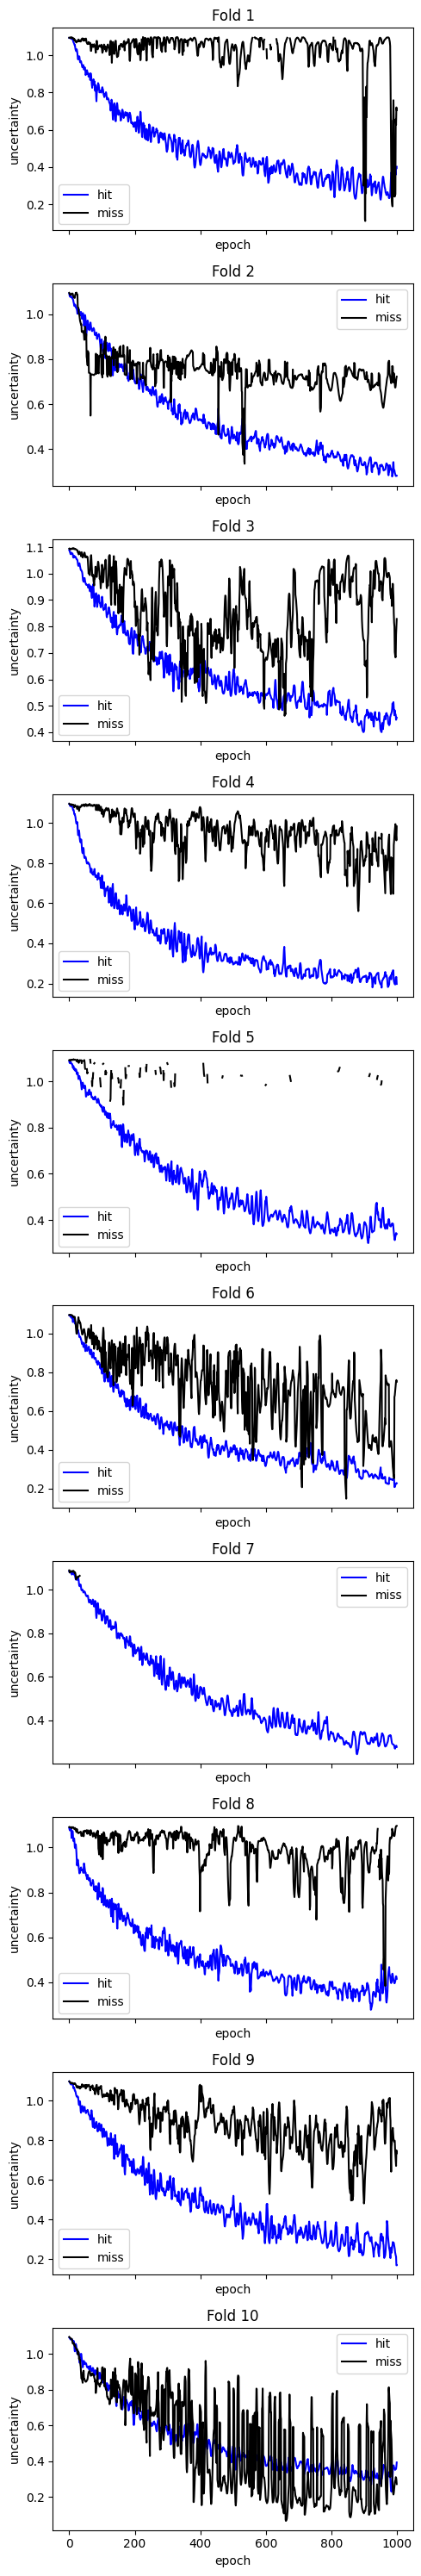

In [24]:
def plot_hit_miss_uncertainty(metrics):
    fig, axes = plt.subplots(len(metrics),1 , figsize=(5, 3*len(metrics)), sharex=True)
    for i,ax in enumerate(axes.ravel()):
        ax.plot(metrics[i]['val']['hit_uncert'], label='hit', color='blue')
        ax.plot(metrics[i]['val']['miss_uncert'], label='miss', color='black')
        ax.set_title(f'Fold {i+1}')
        ax.legend()
        ax.set_xlabel('epoch')
        ax.set_ylabel('uncertainty')
    fig.tight_layout()
    
plot_hit_miss_uncertainty(edl_exp.metrics)


Overall things look good with the exception of fold 10 whose miss uncertainty is bouncing around and below the hit uncertainty.  There are so few samples in the validation set and the accuracy is so high that it means there are very few miss samples making these plots extremely noisy.

####  compare to cross entropy

In [25]:
from torch.nn import functional as F
def make_model_ce():
    return ConvNet(
        activation = None,
        kernel_size_1=15, 
        kernel_size_2=7,
        kernel_maxpool=7,
        hidden_dim=16, 
        dropout=0.5)
criterion = F.cross_entropy
trainer = CrossEntropyTrainer(epochs=1000, criterion=criterion, lr=1e-3, weight_decay=1e-3)
x, y = ft.dataset('sub-01')

models_ce, metrics_ce, scalers_ce, train_splits_ce, val_splits_ce = trainer.fit_kfold(
    make_model_ce, x, y, n_splits=10, batch_size=128, shuffle=True)


Epoch 1000/1000 - train loss: 0.007 acc 100.00% hu 0.007 mu nan val loss: 0.191 acc: 96.30% hu: 0.030 mu: 0.404
Epoch 1000/1000 - train loss: 0.011 acc 100.00% hu 0.010 mu nan val loss: 0.897 acc: 85.19% hu: 0.050 mu: 0.151
Epoch 1000/1000 - train loss: 0.009 acc 100.00% hu 0.009 mu nan val loss: 0.995 acc: 85.19% hu: 0.060 mu: 0.231
Epoch 1000/1000 - train loss: 0.006 acc 100.00% hu 0.006 mu nan val loss: 0.194 acc: 92.59% hu: 0.011 mu: 0.276
Epoch 1000/1000 - train loss: 0.006 acc 100.00% hu 0.006 mu nan val loss: 0.052 acc: 100.00% hu: 0.047 mu: nan8
Epoch 1000/1000 - train loss: 0.005 acc 100.00% hu 0.005 mu nan val loss: 0.274 acc: 88.89% hu: 0.023 mu: 0.288
Epoch 1000/1000 - train loss: 0.012 acc 100.00% hu 0.012 mu nan val loss: 0.038 acc: 100.00% hu: 0.036 mu: nan3
Epoch 1000/1000 - train loss: 0.007 acc 100.00% hu 0.006 mu nan val loss: 0.104 acc: 92.59% hu: 0.039 mu: 0.450
Epoch 1000/1000 - train loss: 0.011 acc 100.00% hu 0.011 mu nan val loss: 0.442 acc: 92.59% hu: 0.053 mu

In [26]:
ce_exp = Experiment('cross entropy', models=models_ce, metrics=metrics_ce, scalers=scalers_ce, train_splits=train_splits_ce, val_splits=val_splits_ce, uncertainty_func=cross_entropy_uncertainty)

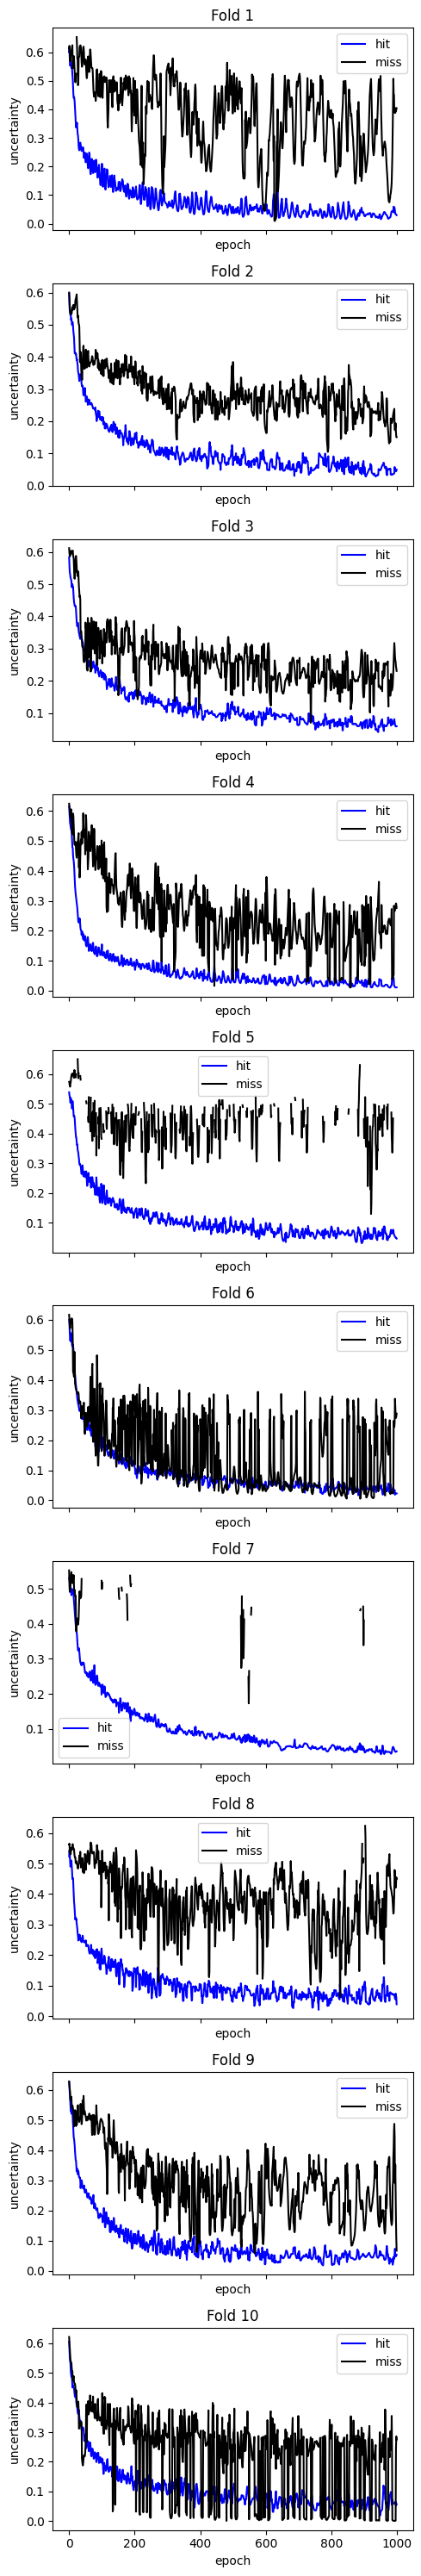

In [27]:
plot_hit_miss_uncertainty(ce_exp.metrics)

Overall these look ok, but fold 6 and 10 are struggling to separate hits and misses.  It's hard to tell the full performance from just these plots especially with all the noise.


Lets quickly make sure that the validation splits are identical

In [28]:
for (u,v) in zip(edl_exp.val_splits, ce_exp.val_splits):
    np.testing.assert_array_equal(u,v)

### Plot Review Curve

We want to answer the question "if we set aside the examples the model is very uncertain about (say for human review), what is the accuracy of the model on the remaining examples that it is more sure about".  To answer this question we plot a review curve (a thing I made up) which shows the accuracy of the model as a function of the number of samples sent for review.  One nice thing about the review curve is that it allows us to compare the performance of different models whose uncertainty scores may be on different scales.  We can measure the area under the review curve (AURC) as a summary metric to systematically compare models.

In [29]:
def review_curve(y, y_pred, uncertainty):
    """Compute the area under the review curve.

    Args:
        y: The true integer labels for the classes.
        y_pred: The predicted integer labels for the classes.
        uncertainty: The uncertainty score for each sample.
    
    Returns:
        (accuracy, percent_reviewed): The accuracy score related
        to each percent reviewed value, sorted in ascending order 
        by percent reviewed.

    """
    uncertainty = np.array(uncertainty)
    umin, umax = uncertainty.min(), uncertainty.max()
    u_range = sorted(set(list(uncertainty) + [umin-1, umax+1]))
    y = np.array(y)
    y_pred = np.array(y_pred)
    #if len(u_range)>1000:
    #    u_range = np.linspace(0,1,1000)
    # else:
    #     u_range = [0] + set(uncertainty)) + [1]

    accuracy = [] 
    percent_reviewed = []
    for u in u_range:
        idx = np.nonzero(uncertainty<u)[0]
        if len(idx)>0:
            acc = np.mean(np.equal(y[idx], y_pred[idx]))
            reviewed = len(idx)
        else:
            acc = 1
            reviewed = 0
        accuracy.append(acc)
        percent_reviewed.append(1-(reviewed/len(y)))
    
    accuracy, percent_reviewed
    acc, pr = tuple(zip(*sorted(zip(accuracy, percent_reviewed), key=lambda x: x[1])))
    return acc, pr

def get_review_curve(experiment, i, x,y):
    """Compute the review curve for a given experiment."""
    exp = experiment
    x_val = exp.scalers[i].transform(x[exp.val_splits[i]])
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_val = torch.tensor(y[exp.val_splits[i]], dtype=torch.int64)
    device = next(exp.models[i].parameters()).device
    with torch.no_grad():
        out = exp.models[i](x_val.to(device)).cpu()
    y_pred = torch.argmax(out, dim=1)
    uncertainty = exp.uncertainty(out)
    acc, pr = review_curve(y_val, y_pred, uncertainty)
    return acc, pr


def plot_review_curve(*experiments, x, y):
    """Plot the review curve for a set of experiments.

    Args:
        experiments: A list of tuples containing the following:
            (y, y_pred, uncertainty, label, color)
    """
    n_folds = len(experiments[0].models)
    fig,axes = plt.subplots(n_folds, 1, figsize=(5,3*n_folds))
    for i, ax in enumerate(axes.ravel()):
        for exp in experiments:
            acc, pr = get_review_curve(exp,i, x, y)
            ax.plot(pr, acc, '-o', label=exp.name)
            ax.set_title(f'Fold {i+1}')
            ax.set_xlabel('percent reviewed')
            ax.set_ylabel('accuracy')
            ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
            ax.legend()
    fig.tight_layout()
    return fig, ax

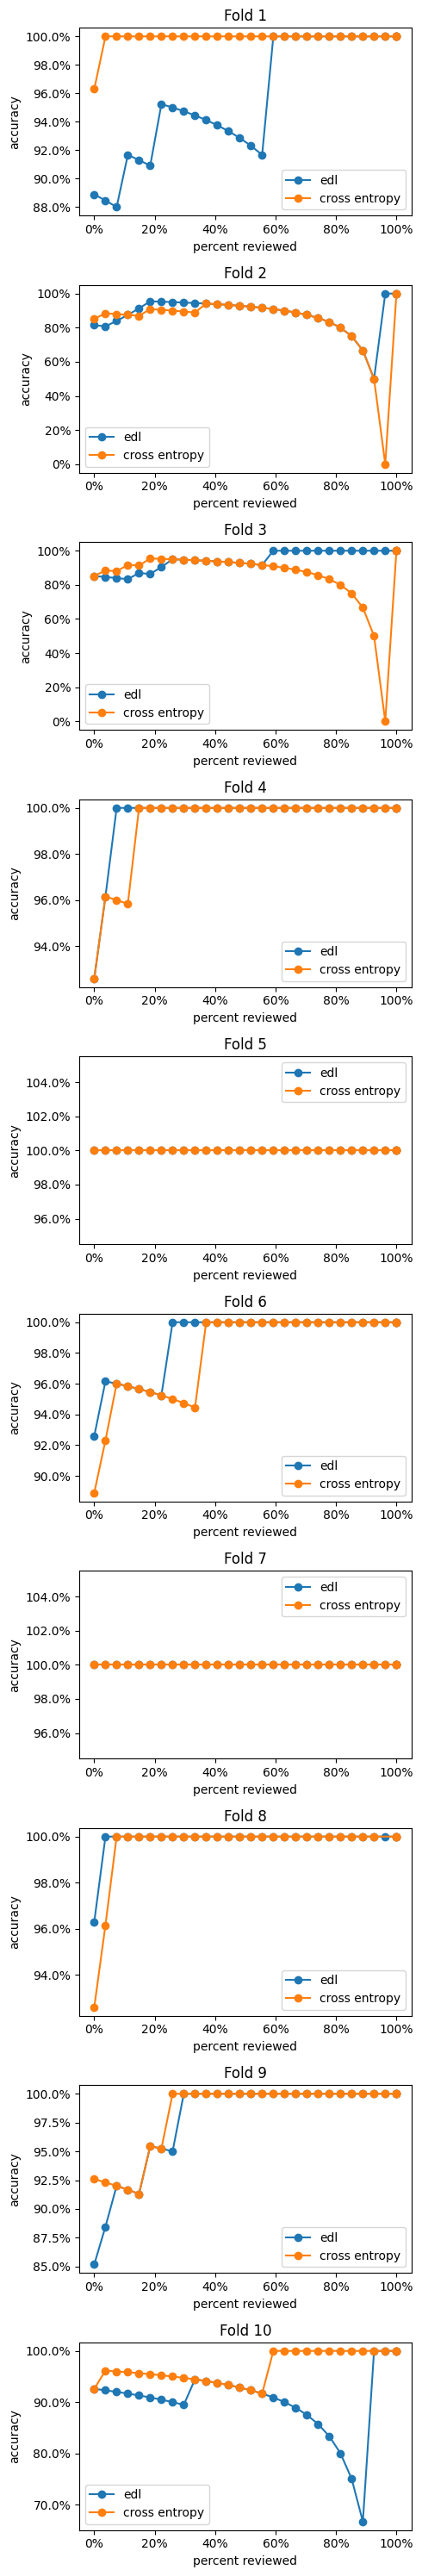

In [30]:
x,y = ft.dataset('sub-01')
_ = plot_review_curve(edl_exp, ce_exp, x=x, y=y)

It seems like these are fairly comparable but the EDL loss does seem to get to 100% accuracy quicker (lower percent reviewed) than cross entropy for most folds (with the exception of 9).  Its not clear how robust this is or how much is noise/low sample size.  That said, we do have other reason to believe that edl would be better.

#### Note on shape of curve
The shape of these curves is jumps, then decreasing until the next jump.  This is a mathematical artifact of the review curve which is being exaggerated by the low sample size.  Let's say a misclassified example has 80% certainty.  Any correct classes < 80% certain will be "sent for review" first as we move along the curve, since there are less examples being scored by the model the accuracy will go down until we reach 80% when the misclassified example gets sent for review, at which time the remaining examples will be more accurate (1 fewer misclassifed) so the accuracy will jump.  The jump points essentially show use exactly where a misclassified example was sent for review.  Ideally these would all be to the "left side" of the curve.

Let's measure the area under these curves as a summary metric of how well they do.

In [31]:
def auc_df(*experiments, x, y ):
    """Area under the review curve for each fold and uncertainty type."""
    n_folds = len(experiments[0].models)
    data = []
    for i in range(n_folds):
        for exp in experiments:
            acc, pr = get_review_curve(exp, i, x, y )
            auc = np.trapz(acc, pr)
            data.append(dict(fold=i+1, auc=auc, experiment=exp.name))
    df = pd.DataFrame(data)
    df = df.pivot(index='fold', columns='experiment', values='auc').reset_index()
    df = pd.DataFrame(df.to_records()).drop('index', axis=1).set_index('fold')
    return df 

x, y = ft.dataset('sub-01')
df = auc_df(edl_exp, ce_exp, x=x, y=y)

print(f"(EDL - Cross Entropy) AUC: {(df['edl'] - df['cross entropy']).mean():.3f}")

(EDL - Cross Entropy) AUC: 0.004


It looks like the EDL loss has ~1.8% more absolute area under the review curve compared to cross entropy averaged over the 10 folds.  This is a pretty underwhelming number but  

1. This is an "easy problem"
2. There is very little data.
3. The accuracy is so high in both cases that both methods are very close to 1 AUC 

------
## Part 2: MaxNorm loss

We implemented the loss function in 
[*Information Aware Max-Norm Dirichlet Networks for Predictive Uncertainty Estimation*](https://arxiv.org/pdf/1910.04819.pdf) which was shown in the paper to give more reliable uncertainty estimates.  We now try re-training with this loss function. 

##### Setup the loss class

In [32]:
class MaxNormLoss(nn.Module):
    """Wrapper for the maxnorm which handles regularization."""
    
    def __init__(self, reg_steps:int, p_norm:int=4, max_reg:int=1, start_reg=0.0):
        super().__init__()
        self.reg_steps = reg_steps
        self.p_norm = 4
        self.max_reg = max_reg
        self.reg_step_size = 1 / self.reg_steps
        self.reg_factor = start_reg

    def forward(self, evidence, y):
        return ul.maxnorm_loss(evidence, y, self.reg_factor, self.p_norm)

    def step(self):
        self.reg_factor = min(self.reg_factor + self.reg_step_size, self.max_reg)

    def reset(self):
        self.reg_factor = 0.0

The paper claims that maxnorm is slower to converge (and seems to converge to worse accuracy) so we lower the learning rate and train for longer.

In [33]:
criterion = MaxNormLoss(reg_steps=1, max_reg=1, p_norm=4)
trainer = UncertaintyTrainer(epochs=1000, criterion=criterion, lr=1e-3, weight_decay=1e-3)
x,y = ft.dataset('sub-01')

models_maxnorm, metrics_maxnorm, scalers_maxnorm, train_splits_maxnorm, val_splits_maxnorm = trainer.fit_kfold(make_model, x, y, n_splits=10, batch_size=128, shuffle=True)

Epoch 1000/1000 - train loss: 0.782 acc 73.02% hu 0.537 mu 0.889 val loss: 0.932 acc: 55.56% hu: 0.727 mu: 1.016
Epoch 1000/1000 - train loss: 0.067 acc 100.00% hu 0.080 mu nan val loss: 129.735 acc: 81.48% hu: 0.156 mu: 0.503
Epoch 1000/1000 - train loss: 0.039 acc 100.00% hu 0.083 mu nan val loss: 1.171 acc: 92.59% hu: 0.307 mu: 0.4679
Epoch 1000/1000 - train loss: 0.039 acc 100.00% hu 0.081 mu nan val loss: 1.217 acc: 92.59% hu: 0.080 mu: 0.9602
Epoch 1000/1000 - train loss: 0.051 acc 100.00% hu 0.103 mu nan val loss: 0.309 acc: 100.00% hu: 0.274 mu: nan8
Epoch 1000/1000 - train loss: 0.220 acc 96.83% hu 0.269 mu 0.519 val loss: 0.335 acc: 92.59% hu: 0.246 mu: 0.6374
Epoch 1000/1000 - train loss: 0.959 acc 65.08% hu 0.700 mu 0.833 val loss: 0.971 acc: 55.56% hu: 0.841 mu: 0.9579
Epoch 1000/1000 - train loss: 0.726 acc 82.54% hu 0.526 mu 0.663 val loss: 0.720 acc: 77.78% hu: 0.738 mu: 1.036
Epoch 1000/1000 - train loss: 1.028 acc 71.43% hu 0.673 mu 0.814 val loss: 0.819 acc: 62.96% h

In [35]:
maxnorm_exp = Experiment('max norm', models=models_maxnorm, metrics=metrics_maxnorm, scalers=scalers_maxnorm, train_splits=train_splits_maxnorm, val_splits=val_splits_maxnorm, uncertainty_func=maxnorm_uncertainty)

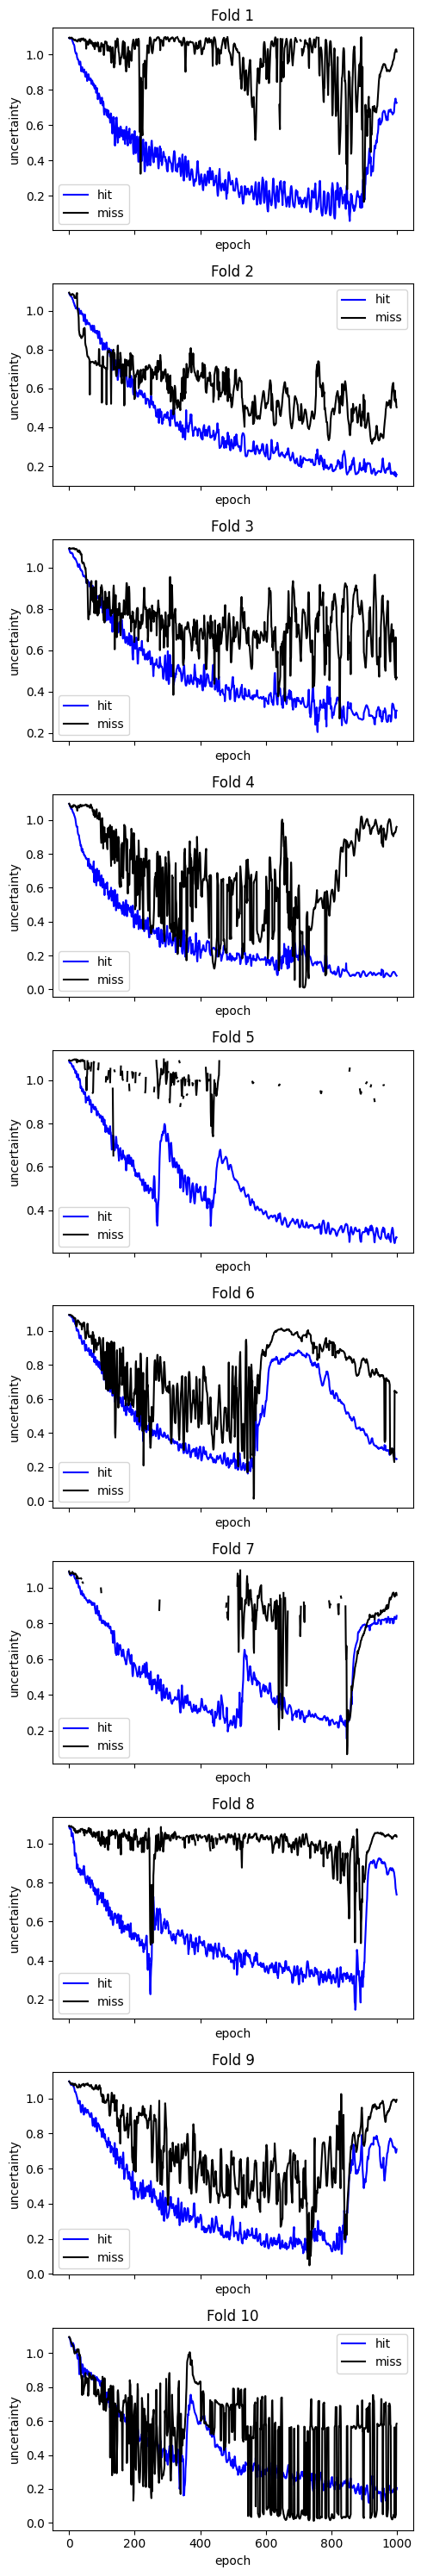

In [36]:
plot_hit_miss_uncertainty(maxnorm_exp.metrics)

Interesting, these plot show that many of the folds have a spike in hit uncertainty but that it's generally decreasing.  Not sure whats causing the spike (exploding gradients??)  We probably need to tune these models a bit more, its unreasonable to think that the exact same hyperparams work since they have different loss landscapes.  For now we will stick with it.

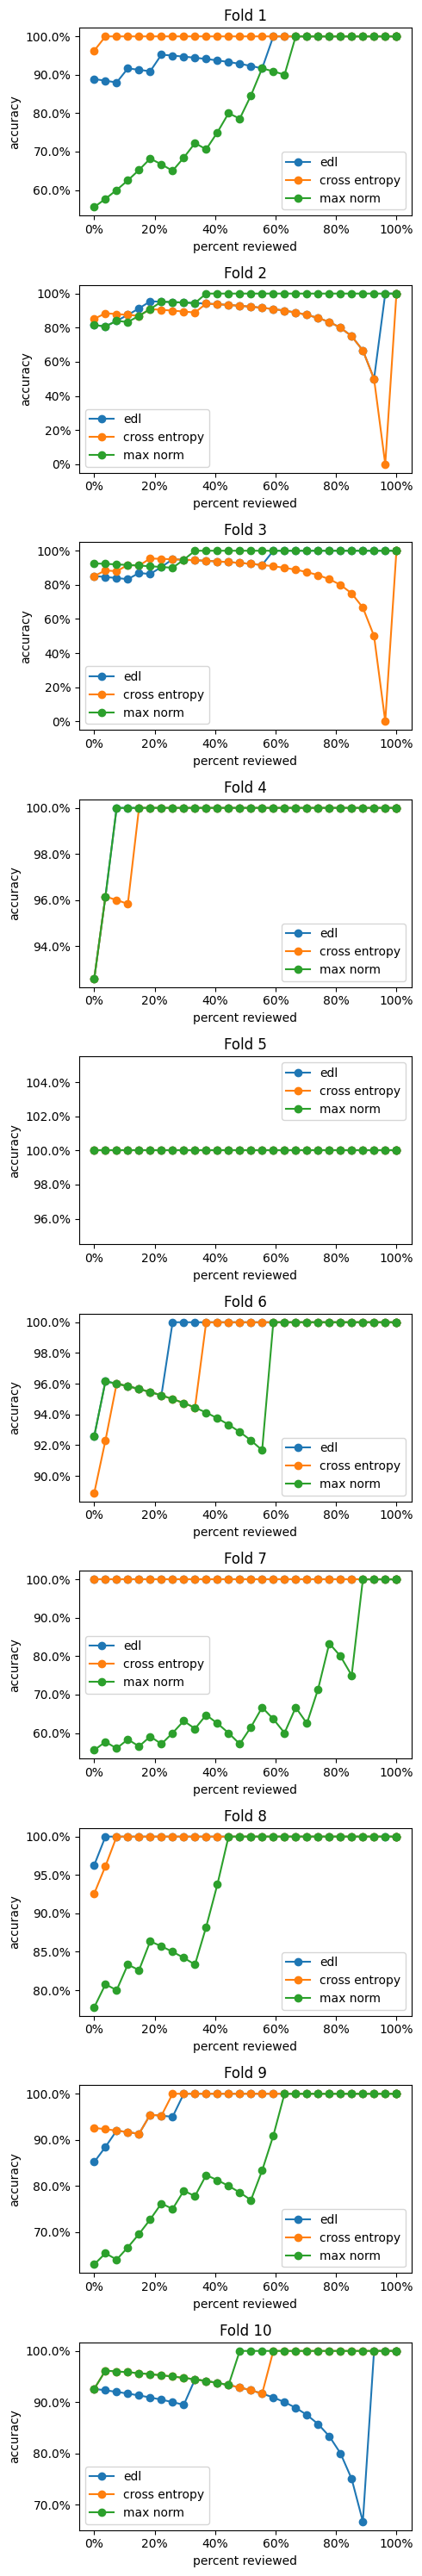

In [37]:
_ = plot_review_curve(edl_exp, ce_exp, maxnorm_exp, x=x, y=y)

This is really interesting and not at all what I expected.  On some examples max norm is a slight favorite and on others is by far the worst (e.g. fold 5).   This might be just due to bad training of the max norm model.  However, the other two models were trained without any tuning so perhaps the maxnorm model is "harder" to tune correctly (or maybe its just these particular params are bad) 

-------
## Part 3 - Train against all subjects

Lets train against all subjects at the same time.

In [38]:
pairs = [ft.dataset(sub) for sub in ft.subject_ids()]
x_all = np.concatenate([x for x,y in pairs])
y_all = np.concatenate([y for x,y in pairs])



def make_model():
    return ConvNet(
        activation = exp_evidence, 
        kernel_size_1=15, 
        kernel_size_2=7,
        kernel_maxpool=7,
        hidden_dim=128, 
        dropout=0.5)
criterion = EDLLoss(reg_steps=100, max_reg=1)
trainer = UncertaintyTrainer(epochs=1000, criterion=criterion, lr=1e-5, weight_decay=1e-3)

_out  = trainer.fit_kfold(make_model, x_all, y_all, n_splits=10, batch_size=128, shuffle=True)


Epoch 1000/1000 - train loss: 0.316 acc 94.92% hu 0.576 mu 1.037 val loss: 0.640 acc: 77.77% hu: 0.558 mu: 0.977
Epoch 1000/1000 - train loss: 0.346 acc 92.38% hu 0.552 mu 1.053 val loss: 0.873 acc: 73.93% hu: 0.671 mu: 0.919
Epoch 1000/1000 - train loss: 0.350 acc 93.33% hu 0.578 mu 1.059 val loss: 0.644 acc: 86.25% hu: 0.621 mu: nan3
Epoch 1000/1000 - train loss: 0.306 acc 93.65% hu 0.521 mu 1.054 val loss: 0.798 acc: 76.79% hu: 0.694 mu: 0.943
Epoch 1000/1000 - train loss: 0.296 acc 95.24% hu 0.530 mu 1.011 val loss: 0.762 acc: 79.02% hu: 0.606 mu: 0.933
Epoch 1000/1000 - train loss: 0.270 acc 96.19% hu 0.540 mu nan val loss: 0.906 acc: 71.43% hu: 0.644 mu: 0.9431
Epoch 1000/1000 - train loss: 0.268 acc 96.51% hu 0.584 mu nan val loss: 0.815 acc: 73.93% hu: 0.652 mu: 0.9269
Epoch 1000/1000 - train loss: 0.356 acc 93.02% hu 0.580 mu 1.047 val loss: 0.815 acc: 79.64% hu: 0.574 mu: 0.887
Epoch 1000/1000 - train loss: 0.337 acc 93.97% hu 0.594 mu 1.045 val loss: 0.703 acc: 78.66% hu: 0.

In [42]:

_out_dict = dict(zip(['models', 'metrics', 'scalers', 'train_splits', 'val_splits'], _out))
_out_dict['uncertainty_func'] = uncertainty
edl_all = Experiment('edl all', **_out_dict)

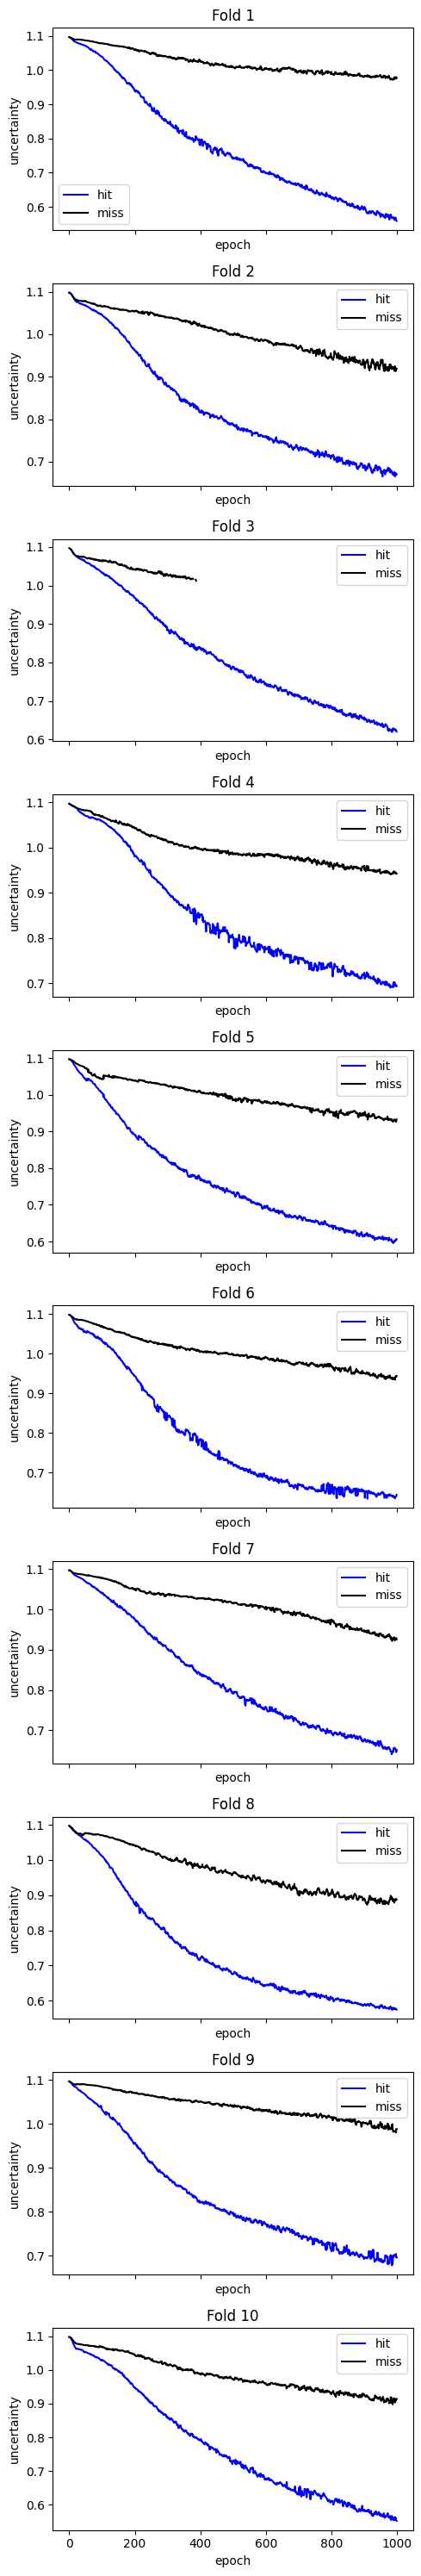

In [43]:
plot_hit_miss_uncertainty(edl_all.metrics)

##### ce on all data

In [44]:
def make_model_ce():
    return ConvNet(
        activation = None, 
        kernel_size_1=15, 
        kernel_size_2=7,
        kernel_maxpool=7,
        hidden_dim=128, 
        dropout=0.5)
criterion = F.cross_entropy
trainer = CrossEntropyTrainer(epochs=1000, criterion=criterion, lr=1e-5, weight_decay=1e-3)

_out  = trainer.fit_kfold(make_model_ce, x_all, y_all, n_splits=10, batch_size=128, shuffle=True)

Epoch 1000/1000 - train loss: 0.148 acc 97.78% hu 0.105 mu 0.457 val loss: 0.449 acc: 81.52% hu: 0.126 mu: 0.309
Epoch 1000/1000 - train loss: 0.180 acc 97.14% hu 0.128 mu 0.444 val loss: 0.647 acc: 71.70% hu: 0.147 mu: 0.339
Epoch 1000/1000 - train loss: 0.171 acc 96.51% hu 0.120 mu 0.383 val loss: 0.419 acc: 87.50% hu: 0.139 mu: nan6
Epoch 1000/1000 - train loss: 0.146 acc 97.14% hu 0.090 mu 0.459 val loss: 0.567 acc: 80.89% hu: 0.187 mu: 0.321
Epoch 1000/1000 - train loss: 0.149 acc 97.46% hu 0.094 mu 0.423 val loss: 0.489 acc: 79.64% hu: 0.140 mu: 0.349
Epoch 1000/1000 - train loss: 0.138 acc 95.87% hu 0.099 mu 0.530 val loss: 0.753 acc: 69.82% hu: 0.152 mu: 0.299
Epoch 1000/1000 - train loss: 0.139 acc 98.10% hu 0.129 mu nan val loss: 0.641 acc: 71.70% hu: 0.139 mu: 0.2900
Epoch 1000/1000 - train loss: 0.170 acc 98.41% hu 0.131 mu 0.285 val loss: 0.499 acc: 83.75% hu: 0.147 mu: nan6
Epoch 1000/1000 - train loss: 0.154 acc 99.37% hu 0.144 mu 0.455 val loss: 0.489 acc: 75.80% hu: 0.

In [45]:
out_dict = dict(zip(['models', 'metrics', 'scalers', 'train_splits', 'val_splits'], _out))
out_dict['uncertainty_func'] = cross_entropy_uncertainty
ce_all = Experiment('ce all', **out_dict)

#### max norm 

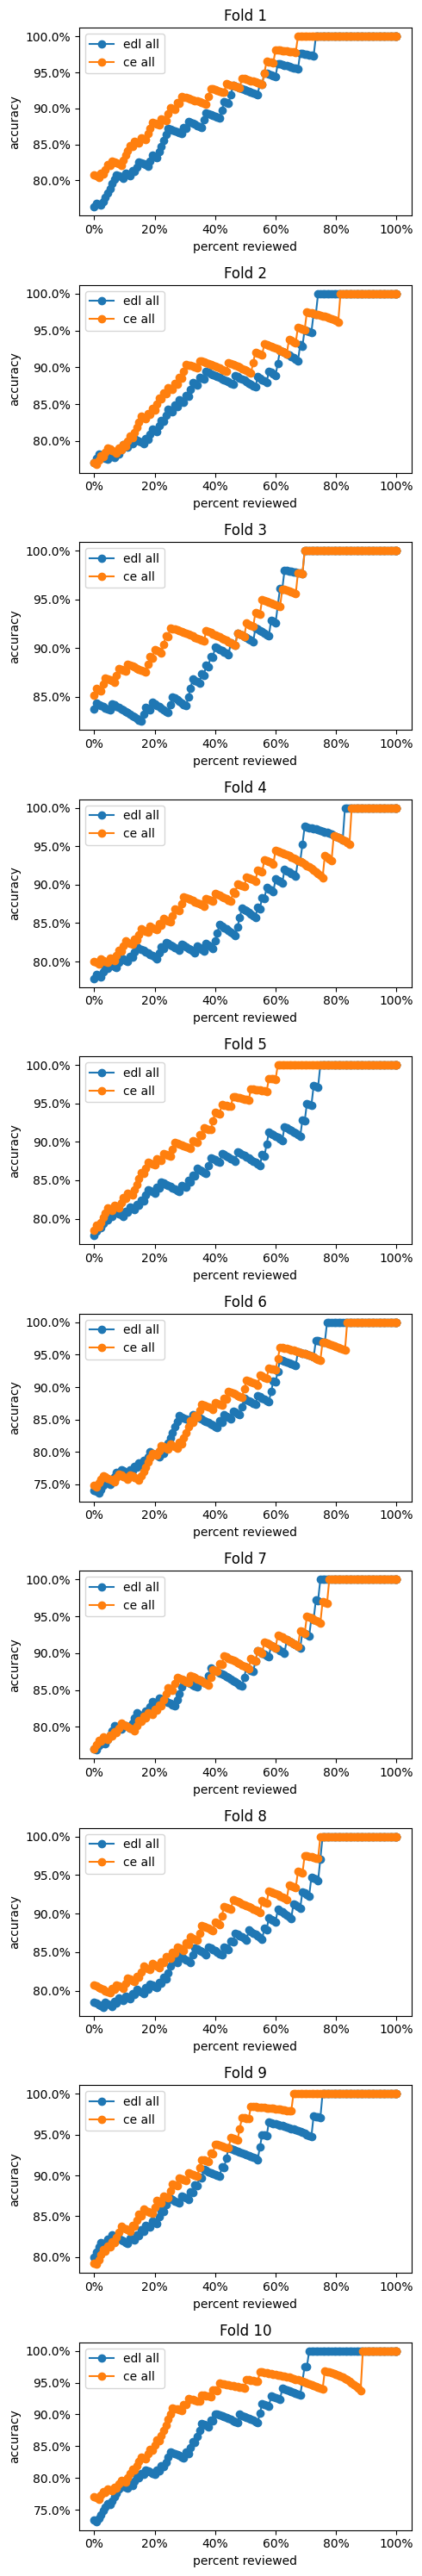

In [46]:
_ = plot_review_curve(edl_all, ce_all, x=x_all, y=y_all)

In [47]:
auc_df(edl_all, ce_all, x=x_all, y=y_all).median()

ce all     0.914705
edl all    0.897909
dtype: float64

##### max norm all

In [48]:
def make_model():
    return ConvNet(
        activation = exp_evidence, 
        kernel_size_1=15, 
        kernel_size_2=7,
        kernel_maxpool=7,
        hidden_dim=128, 
        dropout=0.5)
criterion = MaxNormLoss(reg_steps=100, max_reg=1, p_norm=4)
trainer = UncertaintyTrainer(epochs=1000, criterion=criterion, lr=1e-5, weight_decay=1e-3)
_out  = trainer.fit_kfold(make_model, x_all, y_all, n_splits=10, batch_size=128, shuffle=True)

Epoch 1000/1000 - train loss: 0.431 acc 92.06% hu 0.433 mu 0.957 val loss: 0.724 acc: 80.89% hu: 0.462 mu: 0.931
Epoch 1000/1000 - train loss: 0.427 acc 92.38% hu 0.408 mu 0.963 val loss: 0.920 acc: 72.05% hu: 0.554 mu: 0.867
Epoch 1000/1000 - train loss: 0.478 acc 91.11% hu 0.451 mu 1.027 val loss: 0.711 acc: 87.50% hu: 0.530 mu: nan1
Epoch 1000/1000 - train loss: 0.419 acc 91.11% hu 0.387 mu 0.975 val loss: 0.855 acc: 80.89% hu: 0.604 mu: 0.859
Epoch 1000/1000 - train loss: 0.418 acc 93.33% hu 0.419 mu 0.924 val loss: 0.892 acc: 79.64% hu: 0.493 mu: 0.886
Epoch 1000/1000 - train loss: 0.367 acc 93.33% hu 0.388 mu 1.039 val loss: 1.012 acc: 69.55% hu: 0.537 mu: 0.884
Epoch 1000/1000 - train loss: 0.375 acc 95.24% hu 0.472 mu 1.039 val loss: 0.848 acc: 76.16% hu: 0.555 mu: 0.858
Epoch 1000/1000 - train loss: 0.479 acc 90.16% hu 0.425 mu 0.976 val loss: 0.851 acc: 79.64% hu: 0.473 mu: 0.782
Epoch 1000/1000 - train loss: 0.451 acc 91.11% hu 0.459 mu 0.911 val loss: 0.827 acc: 80.89% hu: 

In [49]:
out_dict = dict(zip(['models', 'metrics', 'scalers', 'train_splits', 'val_splits'], _out))
out_dict['uncertainty_func'] = maxnorm_uncertainty
maxnorm_all = Experiment('max norm all', **out_dict)

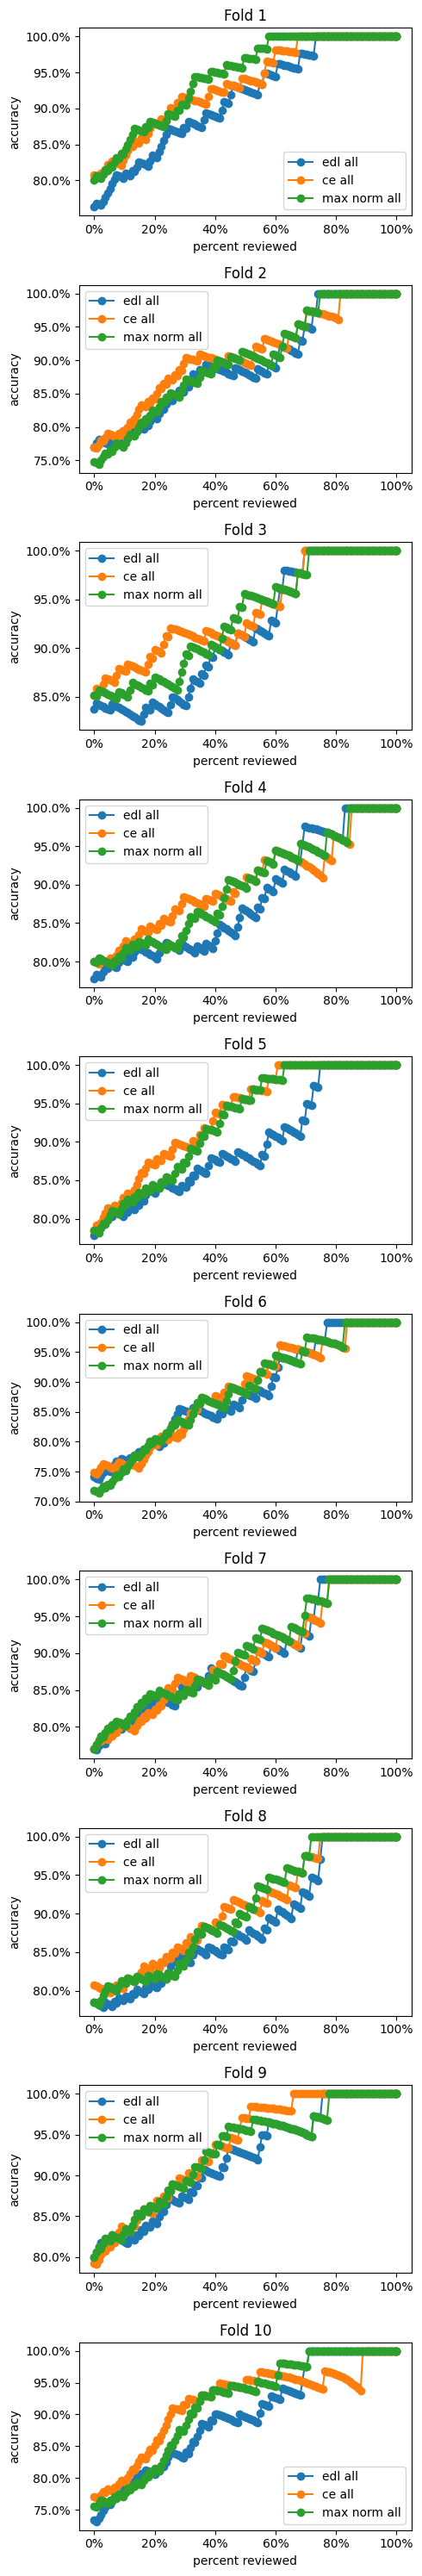

In [50]:
_ = plot_review_curve(edl_all, ce_all, maxnorm_all, x=x_all, y=y_all)

In [51]:
auc_df(edl_all, ce_all, maxnorm_all, x=x_all, y=y_all).median()

ce all          0.914705
edl all         0.897909
max norm all    0.912354
dtype: float64